In [34]:
from pathlib import Path

import pandas as pd
import torch
import numpy as np

In [9]:
DATA_FILEPATH = Path.cwd() / "../data/mimiciii/all_hourly_data.h5"

In [10]:
GAP_TIME          = 6  # In hours
WINDOW_SIZE       = 24 # In hours
SEED              = 1
ID_COLS           = ['subject_id', 'hadm_id', 'icustay_id']

In [ ]:
def simple_imputer(df):
    idx = pd.IndexSlice
    df = df.copy()
    if len(df.columns.names) > 2: df.columns = df.columns.droplevel(('label', 'LEVEL1', 'LEVEL2'))
    
    df_out = df.loc[:, idx[:, ['mean', 'count']]]
    icustay_means = df_out.loc[:, idx[:, 'mean']].groupby(ID_COLS).mean()
    
    df_out.loc[:,idx[:,'mean']] = df_out.loc[:,idx[:,'mean']].groupby(ID_COLS).ffill().groupby(ID_COLS).fillna(icustay_means).fillna(0)
    
    df_out.loc[:, idx[:, 'count']] = (df.loc[:, idx[:, 'count']] > 0).astype(float)
    df_out.rename(columns={'count': 'mask'}, level='Aggregation Function', inplace=True)
    
    is_absent = (1 - df_out.loc[:, idx[:, 'mask']])
    hours_of_absence = is_absent.cumsum()
    time_since_measured = hours_of_absence - hours_of_absence[is_absent==0].ffill()
    time_since_measured.rename(columns={'mask': 'time_since_measured'}, level='Aggregation Function', inplace=True)

    df_out = pd.concat((df_out, time_since_measured), axis=1)
    df_out.loc[:, idx[:, 'time_since_measured']] = df_out.loc[:, idx[:, 'time_since_measured']].fillna(100)
    
    df_out.sort_index(axis=1, inplace=True)
    return df_out

In [31]:
def to_3D_tensor(df):
    idx = pd.IndexSlice
    return np.dstack([df.loc[idx[:,:,:,i], :].values for i in sorted(set(df.index.get_level_values('hours_in')))])

In [15]:
statics  = pd.read_hdf(DATA_FILEPATH, 'patients')
statics.head()

,,,gender,ethnicity,age,insurance,admittime,diagnosis_at_admission,dischtime,discharge_location,fullcode_first,dnr_first,...,outtime,los_icu,admission_type,first_careunit,mort_icu,mort_hosp,hospital_expire_flag,hospstay_seq,readmission_30,max_hours
subject_id,hadm_id,icustay_id,,,,,,,,,,,,,,,,,,,,,
3,145834,211552,M,WHITE,76.526792,Medicare,2101-10-20 19:08:00,HYPOTENSION,2101-10-31 13:58:00,SNF,1.0,0.0,...,2101-10-26 20:43:09,6.064560,EMERGENCY,MICU,0,0,0,1,0,145
4,185777,294638,F,WHITE,47.845047,Private,2191-03-16 00:28:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-23 18:41:00,HOME WITH HOME IV PROVIDR,1.0,0.0,...,2191-03-17 16:46:31,1.678472,EMERGENCY,MICU,0,0,0,1,0,40
6,107064,228232,F,WHITE,65.942297,Medicare,2175-05-30 07:15:00,CHRONIC RENAL FAILURE/SDA,2175-06-15 16:00:00,HOME HEALTH CARE,1.0,0.0,...,2175-06-03 13:39:54,3.672917,ELECTIVE,SICU,0,0,0,1,0,88
9,150750,220597,M,UNKNOWN/NOT SPECIFIED,41.790228,Medicaid,2149-11-09 13:06:00,HEMORRHAGIC CVA,2149-11-14 10:15:00,DEAD/EXPIRED,1.0,0.0,...,2149-11-14 20:52:14,5.323056,EMERGENCY,MICU,1,1,1,1,0,127
11,194540,229441,F,WHITE,50.148295,Private,2178-04-16 06:18:00,BRAIN MASS,2178-05-11 19:00:00,HOME HEALTH CARE,1.0,0.0,...,2178-04-17 20:21:05,1.584410,EMERGENCY,SICU,0,0,0,1,0,38


In [13]:
df = pd.read_hdf(DATA_FILEPATH, 'vitals_labs')
df.head()

LEVEL2                                 alanine aminotransferase             \
Aggregation Function                                      count  mean  std   
subject_id hadm_id icustay_id hours_in                                       
3          145834  211552     0                             2.0  25.0  0.0   
                              1                             0.0   NaN  NaN   
                              2                             0.0   NaN  NaN   
                              3                             0.0   NaN  NaN   
                              4                             0.0   NaN  NaN   

LEVEL2                                 albumin           albumin ascites       \
Aggregation Function                     count mean  std           count mean   
subject_id hadm_id icustay_id hours_in                                          
3          145834  211552     0            2.0  1.8  0.0             0.0  NaN   
                              1            0.0  NaN  NaN             0.0  NaN   
                              2            0.0  NaN  NaN             0.0  NaN   
                              3            0.0  NaN  NaN             0.0  NaN   
                              4            0.0  NaN  NaN             0.0  NaN   

LEVEL2                                     albumin pleural  ...  \
Aggregation Function                   std           count  ...   
subject_id hadm_id icustay_id hours_in                      ...   
3          145834  211552     0        NaN             0.0  ...   
                              1        NaN             0.0  ...   
                              2        NaN             0.0  ...   
                              3        NaN             0.0  ...   
                              4        NaN             0.0  ...   

LEVEL2                                 white blood cell count  \
Aggregation Function                                      std   
subject_id hadm_id icustay_id hours_in                          
3          145834  211552     0                      4.012837   
                              1                           NaN   
                              2                           NaN   
                              3                           NaN   
                              4                           NaN   

LEVEL2                                 white blood cell count urine           \
Aggregation Function                                          count mean std   
subject_id hadm_id icustay_id hours_in                                         
3          145834  211552     0                                 0.0  NaN NaN   
                              1                                 0.0  NaN NaN   
                              2                                 0.0  NaN NaN   
                              3                                 0.0  NaN NaN   
                              4                                 0.0  NaN NaN   

LEVEL2                                    ph                 ph urine           
Aggregation Function                   count  mean       std    count mean std  
subject_id hadm_id icustay_id hours_in                                          
3          145834  211552     0          9.0  7.40  0.147733      1.0  5.0 NaN  
                              1          0.0   NaN       NaN      0.0  NaN NaN  
                              2          3.0  7.26  0.000000      0.0  NaN NaN  
                              3          0.0   NaN       NaN      0.0  NaN NaN  
                              4          0.0   NaN       NaN      0.0  NaN NaN  

[5 rows x 312 columns]

In [18]:
Ys = statics[statics.max_hours > WINDOW_SIZE + GAP_TIME][['mort_hosp', 'mort_icu', 'los_icu']]
Ys['los_3'] = Ys['los_icu'] > 3
Ys['los_7'] = Ys['los_icu'] > 7
Ys.drop(columns=['los_icu'], inplace=True)
Ys.astype(float)

lvl2 = df[
    (df.index.get_level_values('icustay_id').isin(set(Ys.index.get_level_values('icustay_id')))) &
    (df.index.get_level_values('hours_in') < WINDOW_SIZE)
]

train_frac, dev_frac, test_frac = 0.7, 0.1, 0.2
lvl2_subj_idx, Ys_subj_idx = [df.index.get_level_values('subject_id') for df in (lvl2, Ys)]
lvl2_subjects = set(lvl2_subj_idx)
assert lvl2_subjects == set(Ys_subj_idx), "Subject ID pools differ!"

np.random.seed(SEED)
subjects, N = np.random.permutation(list(lvl2_subjects)), len(lvl2_subjects)
N_train, N_dev, N_test = int(train_frac * N), int(dev_frac * N), int(test_frac * N)
train_subj = subjects[:N_train]
dev_subj   = subjects[N_train:N_train + N_dev]
test_subj  = subjects[N_train+N_dev:]

[(lvl2_train, lvl2_dev, lvl2_test), (Ys_train, Ys_dev, Ys_test)] = [
    [df[df.index.get_level_values('subject_id').isin(s)] for s in (train_subj, dev_subj, test_subj)] \
    for df in (lvl2, Ys)
]

idx = pd.IndexSlice
lvl2_means, lvl2_stds = lvl2_train.loc[:, idx[:,'mean']].mean(axis=0), lvl2_train.loc[:, idx[:,'mean']].std(axis=0)

lvl2_train.loc[:, idx[:,'mean']] = (lvl2_train.loc[:, idx[:,'mean']] - lvl2_means)/lvl2_stds
lvl2_dev.loc[:, idx[:,'mean']] = (lvl2_dev.loc[:, idx[:,'mean']] - lvl2_means)/lvl2_stds
lvl2_test.loc[:, idx[:,'mean']] = (lvl2_test.loc[:, idx[:,'mean']] - lvl2_means)/lvl2_stds

In [20]:
lvl2_train, lvl2_dev, lvl2_test = [
    simple_imputer(df) for df in (lvl2_train, lvl2_dev, lvl2_test)
]

for df in lvl2_train, lvl2_dev, lvl2_test: assert not df.isnull().any().any()

/tmp/ipykernel_179799/2355116716.py:9: FutureWarning: DataFrameGroupBy.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_out.loc[:,idx[:,'mean']] = df_out.loc[:,idx[:,'mean']].groupby(ID_COLS).fillna(
/tmp/ipykernel_179799/2355116716.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_out.loc[:,idx[:,'mean']] = df_out.loc[:,idx[:,'mean']].groupby(ID_COLS).fillna(
/tmp/ipykernel_179799/2355116716.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out.rename(columns={'count': 'mask'}, level='Aggregation Function', inplace=True)
/tmp/ipykernel_179799/2355116716.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise 

In [22]:
Ys = statics[statics.max_hours > WINDOW_SIZE + GAP_TIME][['mort_hosp', 'mort_icu', 'los_icu']]
Ys['los_3'] = Ys['los_icu'] > 3
Ys['los_7'] = Ys['los_icu'] > 7
Ys.drop(columns=['los_icu'], inplace=True)
Ys.astype(float)
[(Ys_train, Ys_dev, Ys_test)] = [
    [df[df.index.get_level_values('subject_id').isin(s)] for s in (train_subj, dev_subj, test_subj)] \
    for df in (Ys,)
]

In [54]:
X_train = torch.from_numpy(to_3D_tensor(lvl2_train.loc[:, pd.IndexSlice[:, 'mean']]).astype(np.float32))
Y_train = torch.from_numpy(Ys_train.values.astype(np.int64))
print(X_train.shape)
print(Y_train.shape)

torch.Size([16760, 104, 24])
torch.Size([16760, 4])


In [55]:
print(X_train[1000])
print(Y_train[1000])

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1821,  0.1821,  0.1821,  ..., -0.3215, -0.3215, -0.3215],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
tensor([0, 0, 0, 0])


In [56]:
print(torch.mean(X_train, dim=0))
print(torch.std(X_train, dim=0))


tensor([[-6.5309e-02, -6.5219e-02, -6.4588e-02,  ..., -6.3912e-02,
         -6.3586e-02, -6.3790e-02],
        [ 3.5038e-02,  3.4359e-02,  3.3021e-02,  ...,  1.5625e-02,
          1.4301e-02,  1.3290e-02],
        [ 1.7782e-11,  1.7782e-11,  1.7782e-11,  ...,  1.7782e-11,
          1.7782e-11,  1.7782e-11],
        ...,
        [-1.2061e-02, -1.4655e-02, -1.5165e-02,  ...,  4.3676e-03,
          5.0095e-03,  5.3206e-03],
        [-9.9786e-04,  1.1045e-03,  3.4469e-03,  ..., -3.9437e-02,
         -4.1601e-02, -4.3474e-02],
        [-1.9659e-04, -1.5752e-04, -1.2957e-04,  ..., -2.8179e-04,
         -2.9970e-04, -4.4784e-04]])
tensor([[0.4258, 0.4231, 0.4289,  ..., 0.4123, 0.4105, 0.4081],
        [0.6207, 0.6198, 0.6185,  ..., 0.6104, 0.6092, 0.6096],
        [0.0546, 0.0546, 0.0546,  ..., 0.0546, 0.0546, 0.0546],
        ...,
        [0.8095, 0.8120, 0.8111,  ..., 0.8178, 0.8176, 0.8178],
        [0.9639, 0.9629, 0.9453,  ..., 0.8095, 0.8049, 0.7927],
        [0.3380, 0.3381, 0.3383,  .

<Axes: ylabel='Frequency'>

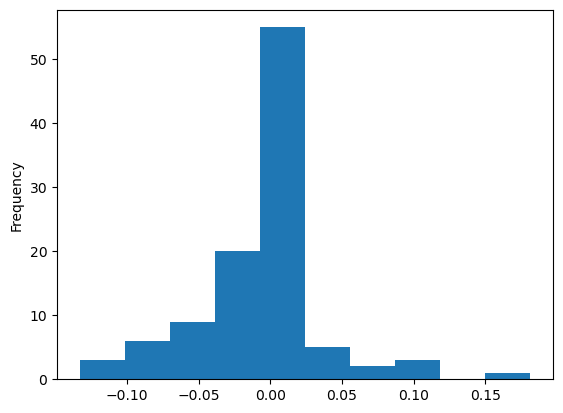

In [63]:
lvl2_train.loc[:, idx[:,'mean']].mean(axis=0).plot(kind="hist")

<Axes: ylabel='Frequency'>

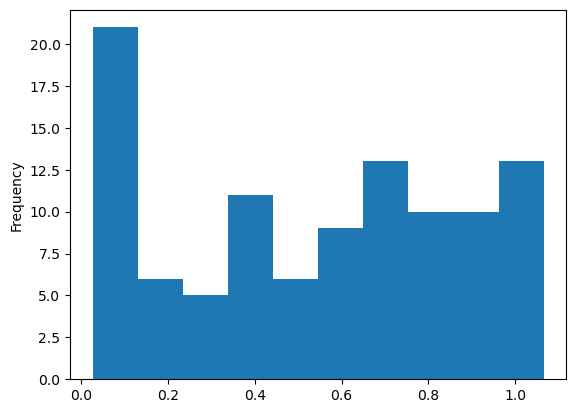

In [64]:
lvl2_train.loc[:, idx[:,'mean']].std(axis=0).plot(kind="hist")

/tmp/ipykernel_179799/157780906.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train.mean(dim=0).flatten())
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_cont

<Axes: ylabel='Density'>

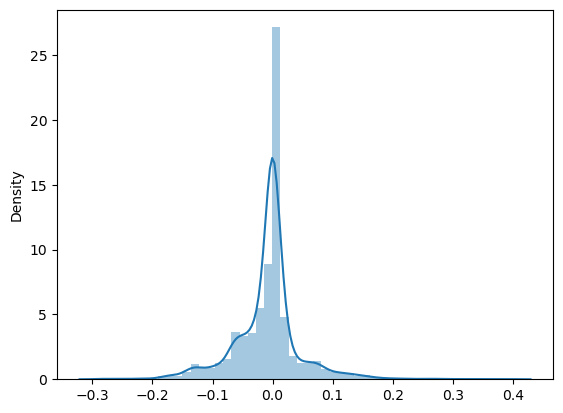

In [77]:
import seaborn as sns

X_train = torch.load(Path.cwd() / "../data/mimiciii/X_train.pt")
sns.distplot(X_train.mean(dim=0).flatten())


<Axes: >

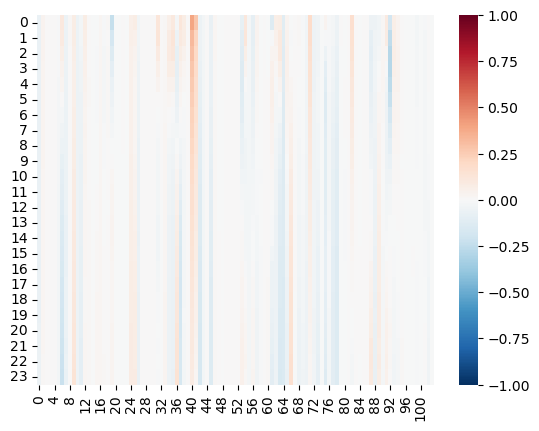

In [79]:
sns.heatmap(X_train.mean(dim=0), vmin=-1, vmax=1, cmap="RdBu_r")

/tmp/ipykernel_179799/3314006042.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train.std(dim=0).flatten())
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_cont

<Axes: ylabel='Density'>

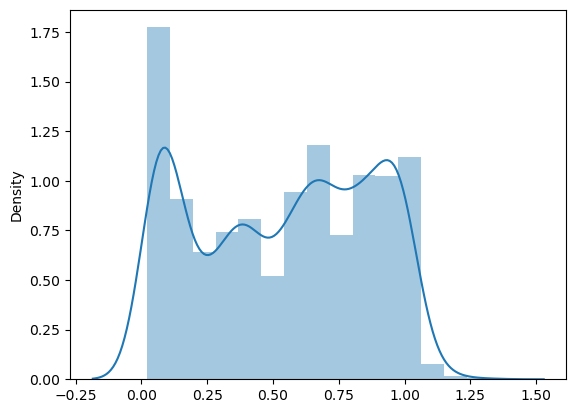

In [76]:
sns.distplot(X_train.std(dim=0).flatten())

<Axes: >

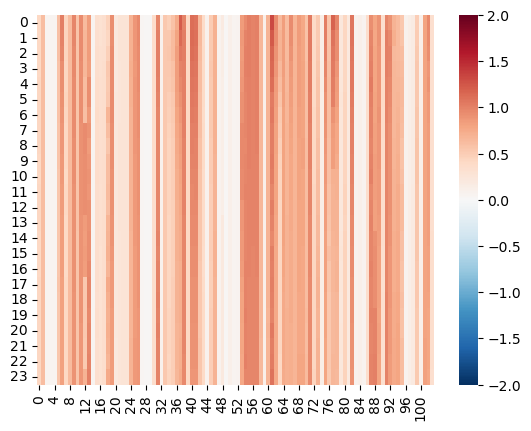

In [84]:
sns.heatmap(X_train.std(dim=0), vmin=-2, vmax=2, cmap="RdBu_r")

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

<Axes: >

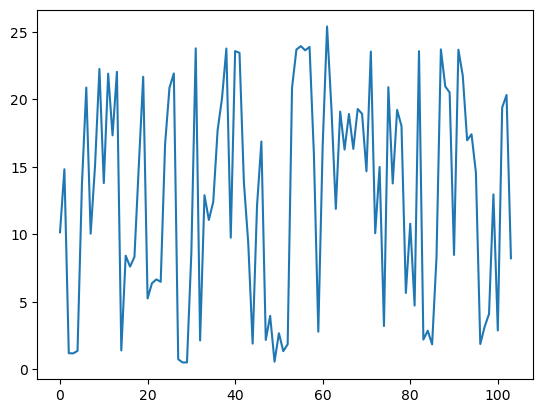

In [89]:
sns.lineplot(X_train.std(dim=0).sum(dim=0))

/tmp/ipykernel_179799/1785037963.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dft(X_train).mean(dim=0))
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context(

<Axes: ylabel='Density'>

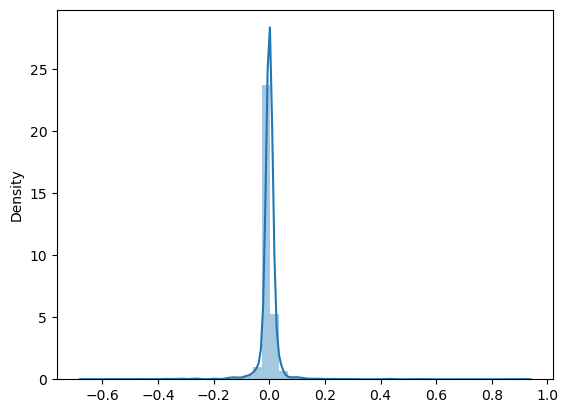

In [75]:
from fdiff.utils.fourier import dft
sns.distplot(dft(X_train).mean(dim=0))

<Axes: >

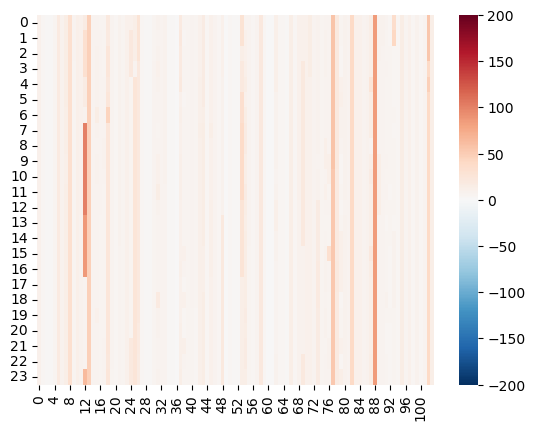

In [116]:
X_norm = (X_train - X_train.mean(dim=0))/X_train.std(dim=0)
sns.heatmap(X_train.max(0)[0], vmin=-200, vmax=200, cmap="RdBu_r")

In [117]:
X_train_dft = dft(X_train)
X_demean_dft = X_train_dft - X_train_dft.mean(dim=0)
X_demean = X_train - X_train.mean(dim=0)

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

Text(0, 0.5, 'Singular value')

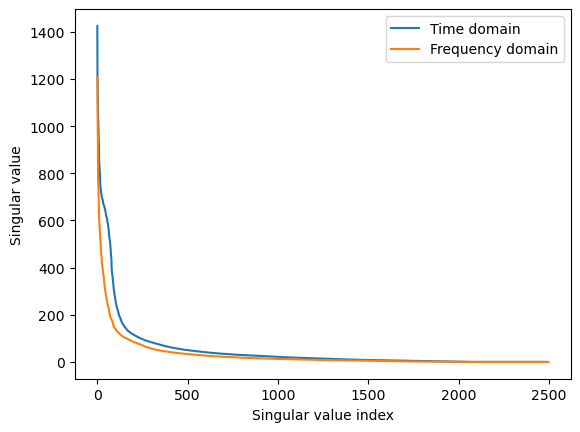

In [118]:
import matplotlib.pyplot as plt

sns.lineplot(torch.svd(X_norm.flatten(start_dim=1))[1], label="Time domain")
sns.lineplot(torch.svd(X_demean.flatten(start_dim=1))[1], label="Frequency domain")
plt.legend()
plt.xlabel("Singular value index")
plt.ylabel("Singular value")

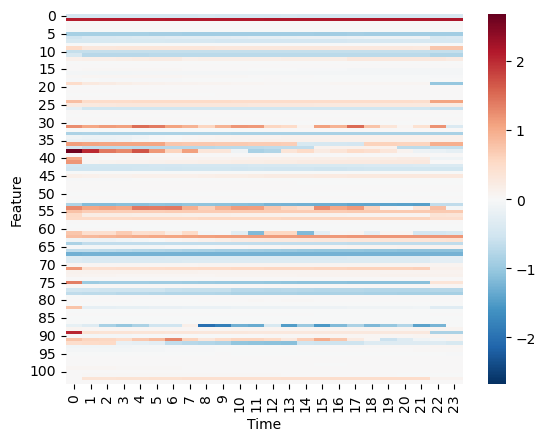

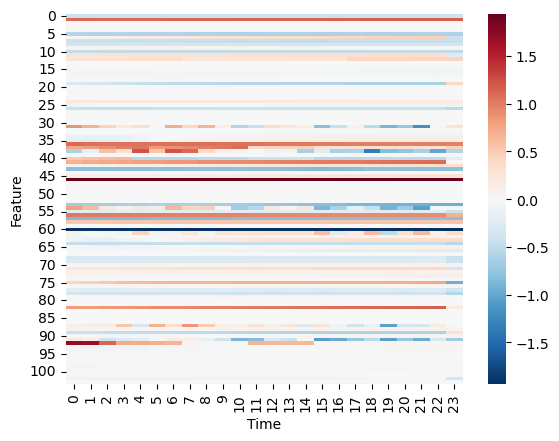

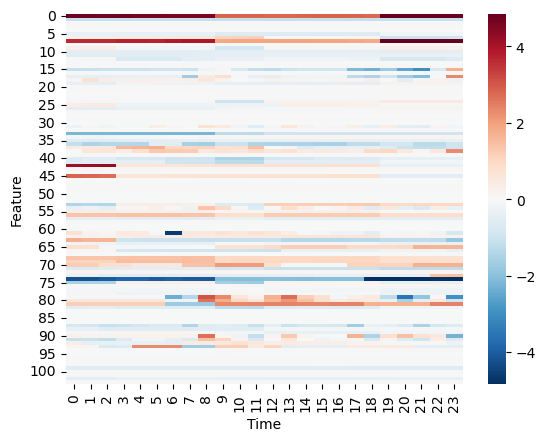

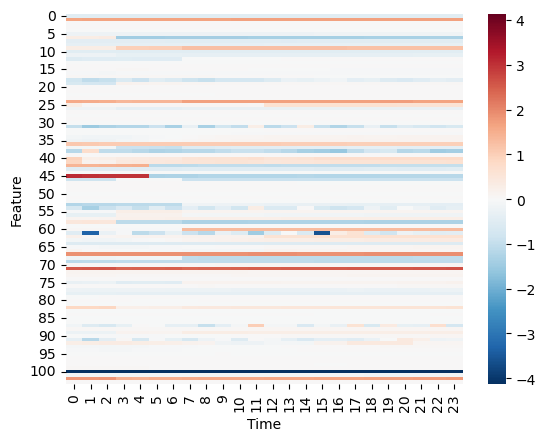

In [135]:
for idx in [666, 777, 42, 12]:
    max_val = torch.abs(X_train[idx]).max(dim=0)[0].max(dim=0)[0]
    sns.heatmap(X_norm[idx].transpose(1, 0), cmap="RdBu_r", vmin=-max_val, vmax=max_val)
    plt.xlabel("Time")
    plt.ylabel("Feature")
    plt.show()
    plt.close()

<Axes: >

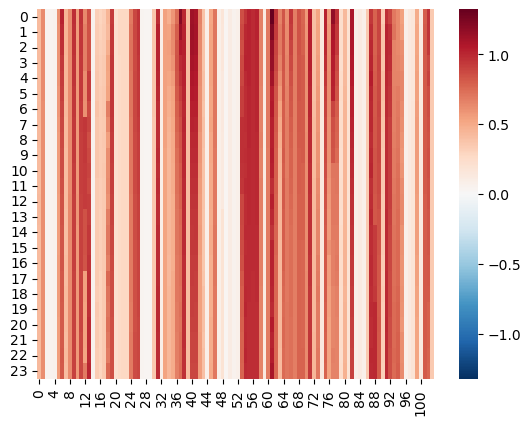

In [138]:
max_val = X_train.std(0).max()
sns.heatmap(X_train.std(0), vmin=-max_val, vmax=max_val, cmap="RdBu_r")

tensor([ 61,  55,  57,  31,  38,  87,  54,  91,  56,  40,  82,  71,  41,   9,
         13,  26,  11,  92,  19,  88,  75,   6,  53,  25,  89, 102,  37, 101,
         62,  68,  77,  64,  69,  66,  78,  36,  94,  12,  93,  46,  24,  60,
         67,  65,  58,  18,   8,  73,   1,  70,  95,  42,  10,  76,   5,  99,
         33,  35,  45,  63,  34,  80,   0,  72,   7,  39,  43,  30,  90,  15])


<Axes: >

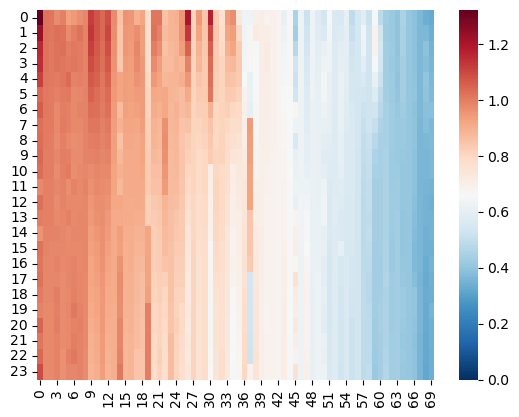

In [152]:
top_feats = torch.argsort(X_train.std(0).mean(0), descending=True)[:70]
print(top_feats)
sns.heatmap(X_train[:, :,  top_feats].std(0), vmin=0, vmax=max_val, cmap="RdBu_r")